<a href="https://colab.research.google.com/github/MaduFavour/Coding-Samples/blob/main/MotionPlannerTeach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AmNext/CrowdModel (1)

/content/drive/MyDrive/AmNext/CrowdModel (1)


##Libraries

In [ ]:
import math
import sys
import torch
import numpy as np
import pandas as pd
from xml.etree import ElementTree as ET
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle
import argparse
import glob
import torch.distributions.multivariate_normal as torchdist
from utils import * 
from metrics import * 
from model import social_stgcnn
import copy

In [ ]:
import os
#this allows pygame to create visualizations
os.environ["SDL_VIDEODRIVER"] = "dummy"
from google.colab.patches import cv2_imshow
from google.colab import output

In [ ]:
###Import all mapUtils functions here###
from mapUtils import *

pygame 2.3.0 (SDL 2.24.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
import pygame, os, math, time, random, copy
from pygame.locals import *

In [ ]:
pygame.init()

(4, 1)

## Constants and Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Robot and Obstacle Parameters

In [ ]:
# Units here are in metres and radians using our standard coordinate frame
BARRIERRADIUS = 0.25 #radius of dynamic obstacles
STATICBARRIERTHICKNESS = 0.1 #radius of static obstacles
ROBOTRADIUS = 0.20 #Radius of robot

W = 2 * ROBOTRADIUS # width of robot

#YOU MAY MODIFY SAFEDIST TO MEET YOUR GOALS
SAFEDIST = ROBOTRADIUS + BARRIERRADIUS      # safety radius used in the cost function for avoiding obstacles

MAXVELOCITY = 0.5    #ms^(-1) max speed of each wheel
MAXACCELERATION = 0.8#0.8#0.2 #ms^(-2) max rate we can change speed of each wheel

BARRIERVELOCITYRANGE = 0.15


### Dataset Parameters

In [ ]:
# Select dataset to work with and set corresponding world parameters

#CHANGE TO DATASET YOU ARE WORKING WITH : 'seq_eth' for eth and 'seq_hotel' for hotel
datasetName = 'seq_eth' 
mapParameters = setMapParameters(datasetName)
[variables,linebarriers,circlebarriers] = getmap(mapParameters[0],mapParameters[4])
[pathXML, WIDTH, HEIGHT, H, H_inv, x_initial, y_initial, x_goal, y_goal, data_number, theta_initial, map_image] = mapParameters

### Region of Interest

In [ ]:
#region of Interest
xmin = -7.0 
ymin = -3.0
xmax= 14.0 
ymax= 3.0 
PLAYFIELDCORNERS = (xmin, ymin, xmax, ymax)

### Constants for Graphics

In [ ]:
size = [WIDTH, HEIGHT]

#Define some colors for visualization - these vectors are flipped (b,g,r) instead of (r,g,b)
black = (0,0,0)
lightblue = (250,120,0)
darkblue = (160,40,0)
red = (0,0,255)
white = (255,255,255)
blue = (255,0,0)
grey = (70,70,70)
yellow = (0,255,255)
green = (0,255,0)
purple = (255,0,255)
orange = (0,165,255)

# Screen centre will correspond to (x, y) = (0, 0)
u0 = WIDTH/2 
v0 = HEIGHT/2

# Initialise Pygame display screen
screen = pygame.display.set_mode(size)

# This makes the normal mouse pointer invisible in graphics window
pygame.mouse.set_visible(0)

# Array for path choices use for graphics 
pathstodraw = []

## Functions to generate obstacles

In [ ]:
#calculate barrier dimensions from points in linebarriers
staticbarriers = linebarriers
barrierlengths = []
for (i,statbarrier) in enumerate(staticbarriers): 
  barrierlengths = np.append(barrierlengths,np.linalg.norm(statbarrier[0:2]- statbarrier[2:]))
barrierlengths = np.array([barrierlengths])
barrierwidths = np.ones_like(barrierlengths)
barrierdims = np.append(barrierlengths,barrierwidths, axis=0)

staticbarriers=np.append(staticbarriers, np.transpose(barrierdims), axis=1)


### Graphics functions

In [ ]:
def moveBarriers(dt):
  for (i, barrier) in enumerate(barriers):
    barriers[i][0] += barriers[i][2] * dt
    if (barriers[i][0] < PLAYFIELDCORNERS[0]):
            barriers[i][2] = -barriers[i][2]
    if (barriers[i][0] > PLAYFIELDCORNERS[2]):
            barriers[i][2] = -barriers[i][2]
    barriers[i][1] += barriers[i][3] * dt
    if (barriers[i][1] < PLAYFIELDCORNERS[1]):
            barriers[i][3] = -barriers[i][3]
    if (barriers[i][1] > PLAYFIELDCORNERS[3]):
            barriers[i][3] = -barriers[i][3]

def drawBarriers(barriers):
  for (i,barrier) in enumerate (barriers):
    bar = np.array([[barrier[0],barrier[1]]])
    bar = world2image(bar, H_inv)
    barrier = np.reshape(bar,(2,))
    bcol = red
    pygame.draw.circle(screen, bcol, (int(barrier[1]), int(barrier[0])), int( k*BARRIERRADIUS), 0)

### Position prediction

In [ ]:
# Function to predict new robot position based on current pose and velocity controls
# Uses time deltat in future
# Returns xnew, ynew, thetanew, path. Path is just used for graphics, and returns some complicated stuff
# used to draw the possible paths during planning. Don't worry about the details.
def predictPosition(vL, vR, x, y, theta, deltat):
        
        if (round (vL,3) == round(vR,3)): # Straight line motion (Pure translation)
                xnew = x + vL * deltat * math.cos(theta)
                ynew = y + vL * deltat * math.sin(theta)
                thetanew = theta
                path = (0, vL * deltat)   # 0 indicates pure translation
        
        elif (round(vL,3) == -round(vR,3)): # Pure rotation motion
                xnew = x
                ynew = y
                thetanew = theta + ((vR - vL) * deltat / W)
                path = (1, 0) # 1 indicates pure rotation
       
        else:  #Combination of both
                num_arc_points = 3;
                arc_points = np.zeros(shape=(num_arc_points,2))

                R = W / 2.0 * (vR + vL) / (vR - vL) #radius of the curve
                deltatheta = (vR - vL) * deltat / W #arc angle
                xnew = x + R * (math.sin(deltatheta + theta) - math.sin(theta))
                ynew = y - R * (math.cos(deltatheta + theta) - math.cos(theta))
                thetanew = theta + deltatheta
                deltatheta_step = 0
                for i in range(0,num_arc_points):
                   deltatheta_step = deltatheta_step + deltatheta/num_arc_points
                   x_stepnew = x + R * (math.sin(deltatheta_step + theta) - math.sin(theta))
                   y_stepnew = y - R * (math.cos(deltatheta_step + theta) - math.cos(theta))
                   arc_points[i,:] = x_stepnew,y_stepnew
  
                path = (2, (arc_points[:,0],arc_points[:,1]))

        return (xnew, ynew, thetanew, path)

### Find distance to closest obstacle 

In [ ]:
# Used for motion planning
def calculateClosestObstacleDistance(x, y):
        closestdist = 100000.0  #initialize to arbitrary big number

        #moving barriers
        for (i,barrier) in enumerate(barriers): 
          dx = barrier[0] - x
          dy = barrier[1] - y
          d = math.sqrt(dx**2 + dy**2)
          # Distance between closest touching point of circular robot and circular barrier
          dist = d - BARRIERRADIUS - W

          if (dist < closestdist):  #update closestdist
            closestdist = dist
        
        #circular static barriers
        for (i,barrier) in enumerate(circlebarriers): 
          dx = barrier[0] - x
          dy = barrier[1] - y
          d = math.sqrt(dx**2 + dy**2)
          # Distance between closest touching point of circular robot and circular barrier
          dist = d - BARRIERRADIUS - 0.2  #0.2 is circlebarrier radius
          if (dist < closestdist): #update closestdist
                  closestdist = dist        

        #rectangular static barriers
        for (_,staticbarrier) in enumerate(staticbarriers): 
          yaw = np.arctan2(staticbarrier[ 3]-staticbarrier[ 1],staticbarrier[ 2]-staticbarrier[ 0]) 

          center_ob = np.array([(staticbarrier[ 2]+staticbarrier[0])/2,(staticbarrier[ 3]+staticbarrier[ 1])/2])
          local_ob =  center_ob- np.array([x,y])

          #check each side to see if robot is already inside obstacle
          upper_check = local_ob[0] <= staticbarrier[4]*np.cos(yaw)/ 2 + ROBOTRADIUS 
          right_check = local_ob[1] <= staticbarrier[5]*np.sin(yaw) / 2 + ROBOTRADIUS 
          bottom_check = local_ob[0] >= -staticbarrier[4]*np.cos(yaw) / 2 - ROBOTRADIUS
          left_check = local_ob[1] >= -staticbarrier[5]*np.sin(yaw)/ 2 - ROBOTRADIUS

          if (np.logical_and(np.logical_and(upper_check, right_check),
                           np.logical_and(bottom_check, left_check))).any():
            return float(-1) 
            
          else: #robot is outside obstacle - calculate dist to obstacle
            d = math.sqrt((center_ob[0]-x)**2+(center_ob[1]-y)**2)
            dist = d - STATICBARRIERTHICKNESS  - W
          
            if (dist < closestdist): #update closestdist
                  closestdist = dist 

        return closestdist #overall closest distance after checking all types of obstacles

## Import Trained Model

In [ ]:
#run this the first time to find dataset numbers
paths = ['./checkpoint/*social-stgcnn*']
KSTEPS=20

print("*"*50)
print('Number of samples:',KSTEPS)
print("*"*50)


path = paths[0]
exps = glob.glob(path)
exps

**************************************************
Number of samples: 20
**************************************************


['./checkpoint/social-stgcnn-univ',
 './checkpoint/social-stgcnn-hotel',
 './checkpoint/social-stgcnn-eth']

In [ ]:

paths = ['./checkpoint/*social-stgcnn*']
KSTEPS=20

print("*"*50)
print('Number of samples:',KSTEPS)
print("*"*50)


path = paths[0]
exps = glob.glob(path)
exp_path = exps[1] 
print('Model being tested are:',exp_path)

print("*"*50)
print("Evaluating model:",exp_path)

model_path = exp_path+'/val_best.pth'
args_path = exp_path+'/args.pkl'
with open(args_path,'rb') as f: 
    args = pickle.load(f)

stats= exp_path+'/constant_metrics.pkl'
with open(stats,'rb') as f: 
    cm = pickle.load(f)
print("Stats:",cm)



#Data prep  
Temp_Pred_len = 0   # don't store truth frame data for comparison
obs_seq_len = args.obs_seq_len
pred_seq_len =  Temp_Pred_len #args.pred_seq_len
data_set = './datasets/'+args.dataset+'/'

dset_test = TrajectoryDataset4mp(
        data_set+'test/',
        obs_len=obs_seq_len,
        pred_len=pred_seq_len,
        skip=1,norm_lap_matr=True)

loader_test = DataLoader(
        dset_test,
        batch_size=1, #This is irrelative to the args batch size parameter
        shuffle =False,
        num_workers=1)



#Defining the model 
model = social_stgcnn(n_stgcnn =args.n_stgcnn,n_txpcnn=args.n_txpcnn,
output_feat=args.output_size,seq_len=args.obs_seq_len,
kernel_size=args.kernel_size,pred_seq_len=args.pred_seq_len).cuda()
model.load_state_dict(torch.load(model_path))


**************************************************
Number of samples: 20
**************************************************
Model being tested are: ./checkpoint/social-stgcnn-hotel
**************************************************
Evaluating model: ./checkpoint/social-stgcnn-hotel
Stats: {'min_val_epoch': -1, 'min_val_loss': 9999999999999999}
Processing Data .....


100%|██████████| 813/813 [00:20<00:00, 39.40it/s]


<All keys matched successfully>

## Motion Planning Section

In [ ]:
#pip install networkx==2.3

### Motion Planner Parameters

In [ ]:
# Starting pose of robot
x = x_initial
y = y_initial
transformedinitial = world2image(np.array([[x_initial,y_initial]]), H_inv)
xinitial = int(transformedinitial[:,1])
yinitial= int(transformedinitial[:,0])
theta = theta_initial

#target location
target = [x_goal,y_goal]
transformedtarget = world2image(np.array([target]),H_inv)
xt = int(transformedtarget[:,1])
yt = int(transformedtarget[:,0])

# Use for displaying a trail of the robot's positions
locationhistory = []

# Starting wheel velocities
vL = 0.00
vR = 0.00

kob = 30 #obstacle scaling constant for graphics
k = 30 #scaling constant for graphics

# Timestep delta to run control and simulation at
dt = 0.4
STEPSAHEADTOPLAN = 5
TAU = dt * STEPSAHEADTOPLAN

#center of image
u0 = WIDTH/2
v0 = HEIGHT/2

# Planning
#MODIFY THESE WEIGHTS TO MEET YOUR GOALS
FORWARDWEIGHT = 5 #indicates how important it is to move forward 
OBSTACLEWEIGHT = 5000 #indicates how important it is to avoid obstacles

### Main Loop

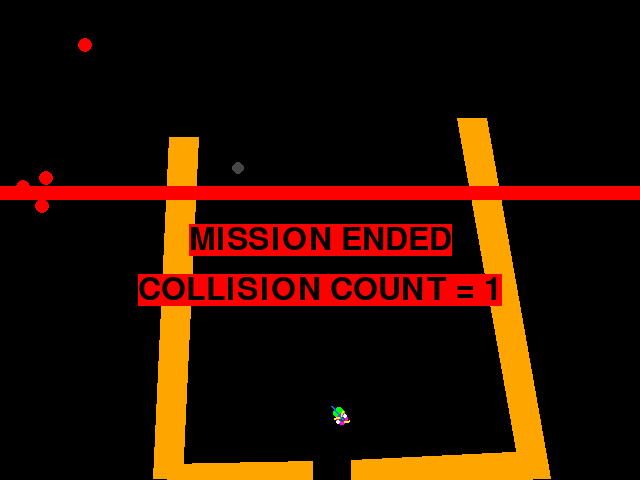

In [ ]:
global loader_test,model
model.eval()
step = 0 
dt = 0.4 # time in between frames
seq_len = 8
collisionCount = 0
frame_count=0
for batch in loader_test: 
        step+=1
        frame_to_display = step + seq_len

        # Get data
        batch = [tensor.cuda() for tensor in batch]
        obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, \
        loss_mask,V_obs,A_obs,V_tr,A_tr,short_seq_obs_traj_tr,instant_pos_obs_traj_tr= batch
         # Also need the short seq data and instantaneous pos data

        num_of_objs = obs_traj_rel.shape[1]
        if num_of_objs>0:
            #Forward
            V_obs_tmp =V_obs.permute(0,3,1,2)

            V_pred,_ = model(V_obs_tmp,A_obs.squeeze())
            V_pred = V_pred.permute(0,2,3,1)

            V_tr = V_tr.squeeze()
            A_tr = A_tr.squeeze()

            V_pred = V_pred.squeeze()
            V_pred,V_tr =  V_pred[:,:num_of_objs,:],V_tr[:,:num_of_objs,:]

            #statistics
            sx = torch.exp(V_pred[STEPSAHEADTOPLAN-1,:,2]) #sx
            sy = torch.exp(V_pred[STEPSAHEADTOPLAN-1,:,3]) #sy
            corr = torch.tanh(V_pred[STEPSAHEADTOPLAN-1,:,4]) #correlation
            cov = torch.zeros(V_pred.shape[1],2,2).cuda()

            cov[:,0,0]= sx*sx
            cov[:,0,1]= corr*sx*sy
            cov[:,1,0]= corr*sx*sy
            cov[:,1,1]= sy*sy

            mean = V_pred[STEPSAHEADTOPLAN-1,:,0:2].squeeze()

            # num of frames by num of peds by x,y
            mvnormal = torchdist.MultivariateNormal(mean,cov)

            pred_traj = mvnormal.sample() #sample_mvnnormal_xy_at_STEPSAHEADTOPLAN
                        
        # For display of trail
        locationhistory.append((x, y))
        
        # Planning
        # We want to find the best benefit where we have a positive component for closeness to target,
        # and a negative component for closeness to obstacles, for each of a choice of possible actions
        bestBenefit = -100000
        FARPOINT = 1e3
        barriers = np.array([FARPOINT,FARPOINT,0,0])
        barriers = barriers.reshape(1,4)
        trueSubjectPositions = np.array([FARPOINT,FARPOINT])
        trueSubjectPositions = (trueSubjectPositions).reshape(1,2)

        num_short_sub = short_seq_obs_traj_tr.size()
        num_inst_sub = instant_pos_obs_traj_tr.size()

        if num_short_sub[-1] > 0:

          short_seq_obs_traj= short_seq_obs_traj_tr.to("cpu").numpy()
          short_seq_obs_traj = np.transpose(short_seq_obs_traj.squeeze(axis=0),(2,1,0)) # Remove singleton related to batch size, and reshape to num_ped by dim by short_seq_len
          trueSubjectPositions= np.concatenate((trueSubjectPositions,short_seq_obs_traj[:,:,-1]),axis=0)

          short_seq_barrier = np.concatenate((short_seq_obs_traj[:,:,-1],np.diff(short_seq_obs_traj[:,:,-2:],axis=2).squeeze(axis=2)/dt),axis=1)
          barriers = np.concatenate((barriers,short_seq_barrier),axis=0)

          moveBarriers(STEPSAHEADTOPLAN*dt)

        
        barriers = barriers[:,0:2]

        if num_inst_sub[-1] >0:
          instant_pos_obs_traj = (instant_pos_obs_traj_tr.to("cpu").numpy())
          instant_pos_obs_traj = np.transpose(instant_pos_obs_traj.squeeze(axis=0),(1,0)) # Squeeze out singleton dimension related to batch size, and transpose to num_ped by dim
          trueSubjectPositions=np.concatenate((trueSubjectPositions,instant_pos_obs_traj),axis=0)
          barriers=np.concatenate((barriers,instant_pos_obs_traj),axis=0)          
          
          
        if num_of_objs > 0:
          obs_traj = np.transpose(obs_traj.to("cpu").numpy().squeeze(axis=0),(0,1,2)) # Squeeze out singleton dimension related to batch size and reshape to num_ped by dim by seq_len
          trueSubjectPositions= np.concatenate((trueSubjectPositions,obs_traj[:,:,-1]),axis=0)

          pred_traj = pred_traj.to("cpu").numpy()
          barriers=np.concatenate((barriers,pred_traj),axis=0) 

        
        # Range of possible motions: each of vL and vR could go up or down a bit
        vLpossiblearray = (vL - MAXACCELERATION * dt, vL, vL + MAXACCELERATION * dt)
        vRpossiblearray = (vR - MAXACCELERATION * dt, vR, vR + MAXACCELERATION * dt)
        pathstodraw = [] # We will store path details here for plotting later
        newpositionstodraw = [] # Also for possible plotting of robot end positions
        for vLpossible in vLpossiblearray:
                for vRpossible in vRpossiblearray:
                        # We can only choose an action if it's within velocity limits
                        if (vLpossible <= MAXVELOCITY and vRpossible <= MAXVELOCITY and vLpossible >= -MAXVELOCITY and vRpossible >= -MAXVELOCITY):
                                # Predict new position in TAU seconds
                                (xpredict, ypredict, thetapredict, path) = predictPosition(vLpossible, vRpossible, x, y, theta, TAU)
                                pathstodraw.append(path)
                                newpositionstodraw.append((xpredict, ypredict))
                                # What is the distance to the closest obstacle from this possible position?
                                distanceToObstacle = calculateClosestObstacleDistance(xpredict, ypredict)
                                # Calculate how much close we've moved to target location
                                previousTargetDistance = math.sqrt((x - target[0])**2 + (y - target[1])**2)
                                newTargetDistance = math.sqrt((xpredict - target[0])**2 + (ypredict - target[1])**2)
                                distanceForward = previousTargetDistance - newTargetDistance

                                # Positive benefit
                                distanceBenefit = FORWARDWEIGHT * distanceForward
                                # Negative cost: once we are less than SAFEDIST from collision, linearly increasing cost
                                if (distanceToObstacle < SAFEDIST):                                 
                                        obstacleCost = OBSTACLEWEIGHT * (SAFEDIST - distanceToObstacle)
                                else:
                                        obstacleCost = 0.0
                                # Total benefit function to optimise
                                benefit = distanceBenefit - obstacleCost

                                if (benefit > bestBenefit):
                                        vLchosen = vLpossible
                                        vRchosen = vRpossible
                                        bestBenefit = benefit

        vL = vLchosen
        vR = vRchosen
        

######## Planning is finished; now do graphics ############
        screen.fill(black)
        draw_map(screen,variables,H_inv,kob)
        
        for loc in locationhistory:
          transloc = world2image(np.array([[loc[0],loc[1]]]),H_inv)
          loc =(transloc[:,1],transloc[:,0])

          pygame.draw.circle(screen, grey, (int(loc[0]), int(loc[1])), int(k*ROBOTRADIUS), 0)

        #Draw the initial position
        pygame.draw.circle(screen, grey, (xinitial,yinitial), int(kob*ROBOTRADIUS), 0)
        #Draw the target position
        pygame.draw.circle(screen, green, (xt,yt), int(kob*ROBOTRADIUS), 0)
        
        #Draw obstacles
        drawBarriers(trueSubjectPositions)
        
        # Draw robot
        u = x
        v = y 

        transformed_uv = world2image(np.array([[u,v]]), H_inv)
        u1 = transformed_uv[:,1] # x and y flipped after transformation
        v1 = transformed_uv[:,0]
    
        pygame.draw.circle(screen, purple, (int(u1), int(v1)), int(k * ROBOTRADIUS), 3)

        # Draw wheels as little blobs so you can see robot orientation
        WHEELBLOB = 0.07
        # left wheel centre 
        wlx = x - (W/2.0) * math.sin(theta)
        wly = y + (W/2.0) * math.cos(theta)
        ulx = wlx
        vly = wly
        transformed_ulxvly = world2image(np.array([[ulx,vly]]), H_inv)
        ulx1 = transformed_ulxvly[:,1] # x and y flipped
        vly1 = transformed_ulxvly[:,0]
        
        pygame.draw.circle(screen, white, (int(ulx1), int(vly1)), int(k * WHEELBLOB))

        # right wheel centre 
        wrx = x + (W/2.0) * math.sin(theta)
        wry = y - (W/2.0) * math.cos(theta)
        urx = wrx
        ury = wry
        transformed_urxvry = world2image(np.array([[urx,ury]]), H_inv)
        urx1 = transformed_urxvry[:,1]# x and y flipped
        vry1 = transformed_urxvry[:,0]

        pygame.draw.circle(screen, white, (int(urx1), int(vry1)), int(k * WHEELBLOB))

        # Draw paths: little arcs which show the different paths the robot is selecting between
        # A bit complicated so don't worry about the details!
        for path in pathstodraw:
          #if path[0] = 1:    # Pure rotation: nothing to draw
          if path[0] == 0:    # Straight line
              straightpath = path[1]
              transformed = world2image(np.array([[x,y]]), H_inv)
              x1 = int(transformed[:,1]) # flipped x and y 
              y1 = int(transformed[:,0])
              linestart0 = (x1, y1)
              transformend0 = world2image(np.array([[(x + straightpath * math.cos(theta)),(y + straightpath * math.sin(theta))]]), H_inv)
              xend0 = int(transformend0[:,1]) # flipped x and y 
              yend0 = int(transformend0[:,0]) 
              lineend0 = ( xend0,yend0)

              pygame.draw.line(screen, lightblue, linestart0, lineend0, 2)
              
          if path[0] == 2:    # General case: circular arc

              for arcindex in range(0,len(path[1])):
                arc_pointsstart = path[1][0][arcindex],path[1][1][arcindex]
                transformedstartarc = world2image(np.array([arc_pointsstart]), H_inv)
                linestart = transformedstartarc[:,1][0],transformedstartarc[:,0][0]
                arc_pointsend = path[1][0][arcindex+1],path[1][1][arcindex+1]
                transformedendarc = world2image(np.array([arc_pointsend]), H_inv)
                lineend = transformedendarc[:,1][0],transformedendarc[:,0][0]

                pygame.draw.line(screen, (0, 255, 255), linestart, lineend, 2)

        # Update display
        pygame.display.update()

        # Actually now move robot based on chosen vL and vR
        (x, y, theta, tmppath) = predictPosition(vL, vR, x, y, theta, dt)

        image = pygame.surfarray.array3d(screen)
        image = image.transpose([1, 0, 2])

       
        if calculateClosestObstacleDistance(x, y) < SAFEDIST: 
          collisionCount += 1

        # Wraparound: check if robot has reached target; 
        disttotarget = math.sqrt((x - target[0])**2 + (y - target[1])**2)
        if (disttotarget < ROBOTRADIUS):
          font = pygame.font.Font('freesansbold.ttf', 32)

          if collisionCount == 0:
            text = font.render('MISSION SUCCESS', True, black, green)
            collisionText =font.render('NO COLLISIONS', True, black, green)
          else:
            text = font.render('MISSION ENDED', True, black, red)
            collisionMessage ="COLLISION COUNT = {0}".format(collisionCount)
            collisionText =font.render(collisionMessage, True, black, red)
          
          # create a rectangular object for the text surface object
          textRect = text.get_rect()
          # set the center of the rectangular object
          textRect.center = (WIDTH // 2, HEIGHT// 2)
          screen.blit(text, textRect)
          #repeat for collision text
          collisionTextRect = collisionText.get_rect()
          collisionTextRect.center = (WIDTH//2, HEIGHT//2+50)
          screen.blit(collisionText, collisionTextRect)

          image = pygame.surfarray.array3d(screen)
          image = image.transpose([1, 0, 2])
          pygame.display.update()
          output.clear(wait=True)
          cv2_imshow(image)   

          break

        # Reset trail
        locationhistory = []

        output.clear(wait=True)
        cv2_imshow(image)        
        # Sleeping dt here runs simulation in real-time
        
        #uncomment the following 3 lines for saving the frames from animation
        frame_count += 1
        filename = "screen_%04d.png" % ( frame_count )
        pygame.image.save( screen, filename )

        time.sleep(dt)

In [ ]:
os.system("ffmpeg -framerate 5 -i screen_%04d.png outputVideo.mp4")

2

In [ ]:
# If you want to delete the saved images from your drive after creating the video, run this part
for filename in glob.glob("screen_*"):
    os.remove(filename) 